In [4]:
import os

# Get the notebook's directory
SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
# Get repository root (two levels up from script directory)
REPO_ROOT = os.path.dirname(os.path.dirname(SCRIPT_DIR))

# data path for step 2
DIM = 128
CLS_NB = 3

# Define paths relative to REPO_ROOT
root = os.path.join(REPO_ROOT, "Data/step1_train_phase1/features/")
train_root = os.path.join(root, "train/")
val_root = os.path.join(root, "val/")
best_model = os.path.join(REPO_ROOT, "Data/step1_train_phase1/fuse_ckpt/model_0.9489462970044914.ckpt")

raw_data_loc = os.path.join(REPO_ROOT, "Data/processed/G0_arrest/TrVal_dataset_QuiescenceStatus.pkl")

import sys
code_loc = os.path.join(REPO_ROOT, "code/")
save_loc = os.path.join(REPO_ROOT, "Data/step2_vis_performance/")
sys.path.append(code_loc)

In [5]:
import torch.nn as nn
class FuseNet(nn.Module):
    def __init__(self,in_dim=DIM*CLS_NB, dropout = 0., h_dim = DIM, out_dim = CLS_NB, ):
        nn.Module.__init__(self,)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=512, bias=True)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_features=512, out_features=h_dim, bias=True)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(in_features=h_dim, out_features=out_dim, bias=True)

    def forward(self, x, out_key:str = "all"):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        if out_key == "fc1":
            return x

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        if out_key == "fc2":
            return x
        x = self.fc3(x)
        if out_key == "all":
            return x
        else:
            raise ValueError("out_key must be one of 'fc1', 'fc2', 'all'")
    

# 从文件夹中读取所有类的feature matrix
import pickle
import numpy as np


read_list = ["cls0","cls1","cls2"]
#-->train
train_feat_list = []
for i in range(len(read_list)):
    with open(train_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        train_feat_list.append(feat)
train_label = label
print(len(train_feat_list),train_feat_list[0].shape,train_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
train_feat = np.concatenate(train_feat_list,axis=1) 

#-->val
val_feat_list = []
for i in range(len(read_list)):
    with open(val_root+read_list[i]+".pkl","rb") as f:
        [feat,label] = pickle.load(f)
        val_feat_list.append(feat)
val_label = label
print(len(val_feat_list),val_feat_list[0].shape,val_label.shape)
# 合并feat_list中的feature matrix，[sample_nb,feat_dim] -> [sample_nb,feat_dim*5]
val_feat = np.concatenate(val_feat_list,axis=1)

# train model 
import torch

train_feat = torch.from_numpy(train_feat).float()
train_label = torch.from_numpy(train_label).long() 
# label from [sample_nb,1] -> [sample_nb,class_nb]
train_label = torch.zeros(train_label.shape[0],CLS_NB).scatter_(1,train_label,1)


val_feat = torch.from_numpy(val_feat).float()
val_label = torch.from_numpy(val_label).long()
# label from [sample_nb,1] -> [sample_nb,class_nb]
val_label = torch.zeros(val_label.shape[0],CLS_NB).scatter_(1,val_label,1)


# get Dataset and DataLoader
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(train_feat,train_label)
valset = TensorDataset(val_feat,val_label)

trainloader = DataLoader(trainset,batch_size=DIM,shuffle=True)
valloader = DataLoader(valset,batch_size=DIM,shuffle=True)

# get model
model = FuseNet(in_dim=DIM*CLS_NB, dropout = 0., h_dim = DIM, out_dim = CLS_NB, )

3 (68599, 128) (68599, 1)
3 (17150, 128) (17150, 1)


In [6]:

model.load_state_dict(torch.load(best_model))

<All keys matched successfully>

In [10]:
import dill
with open(raw_data_loc,"rb") as f:
    [dataset_0,_,_,label_dict] = dill.load(f)
print(label_dict)
# get reverse label dict from label dict
reverse_label_dict = {}
for key in label_dict:
    reverse_label_dict[label_dict[key]] = key

{'G0_arrested': 0, 'Slow_cycling': 1, 'Fast_cycling': 2}


In [11]:
# strat train
from tqdm import tqdm
# roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
model.to("cuda")
best_roc  = 0

# eval
model.eval()
pred_list = []
label_list = []
feat_list = []
for feat,label in tqdm(valloader):
    feat = feat.to("cuda")
    label = label.to("cuda")
    pred = model(feat)
    #pred = F.tanh(pred)+1
    pred=F.softmax(pred,dim=1)
    pred = pred.detach().cpu().numpy()
    pred_list.append(pred)
    label_list.append(label.detach().cpu().numpy())
    feat_list.append(feat.detach().cpu().numpy())
pred_list = np.concatenate(pred_list,axis=0)
label_list = np.concatenate(label_list,axis=0)
emb2_list = np.concatenate(feat_list,axis=0)
# from pred_list and label_list get roc_auc for each class
# 原始的 label_dict

# 构建 reverse_label_dict
reverse_label_dict = {v: k for k, v in label_dict.items()}


for label_idx in label_dict.keys():
    i = label_dict[label_idx]
    print(f"roc_auc_score_{label_idx}: {roc_auc_score(label_list[:,i],pred_list[:,i])}, acc score {accuracy_score(label_list[:,i],pred_list[:,i]>0.5)}")
    print(f" trun positive rate: {np.sum(label_list[:,i])/label_list.shape[0]}")
    print(f"true negative rate: {np.sum(label_list[:,i]==0)/label_list.shape[0]}")
    print(f" false positive rate: {np.sum((label_list[:,i]==0)&(pred_list[:,i]>0.5))/label_list.shape[0]}")
    print(f" false negative rate: {np.sum((label_list[:,i]==1)&(pred_list[:,i]<0.5))/label_list.shape[0]}")


# from pred_list and label_list get average roc_auc_score
score = roc_auc_score(label_list,pred_list,average="macro")
print("average roc_auc_score:",score)

100%|██████████| 134/134 [00:00<00:00, 228.56it/s]

roc_auc_score_G0_arrested: 0.927266516197871, acc score 0.8934110787172012
 trun positive rate: 0.8020991253644315
true negative rate: 0.19790087463556852
 false positive rate: 0.07043731778425656
 false negative rate: 0.036151603498542274
roc_auc_score_Slow_cycling: 0.9793849510329492, acc score 0.9586588921282799
 trun positive rate: 0.10116618075801749
true negative rate: 0.8988338192419825
 false positive rate: 0.014052478134110787
 false negative rate: 0.02728862973760933
roc_auc_score_Fast_cycling: 0.9278297040701344, acc score 0.9347521865889212
 trun positive rate: 0.09673469387755101
true negative rate: 0.9032653061224489
 false positive rate: 0.022099125364431486
 false negative rate: 0.04314868804664723
average roc_auc_score: 0.9448270571003183


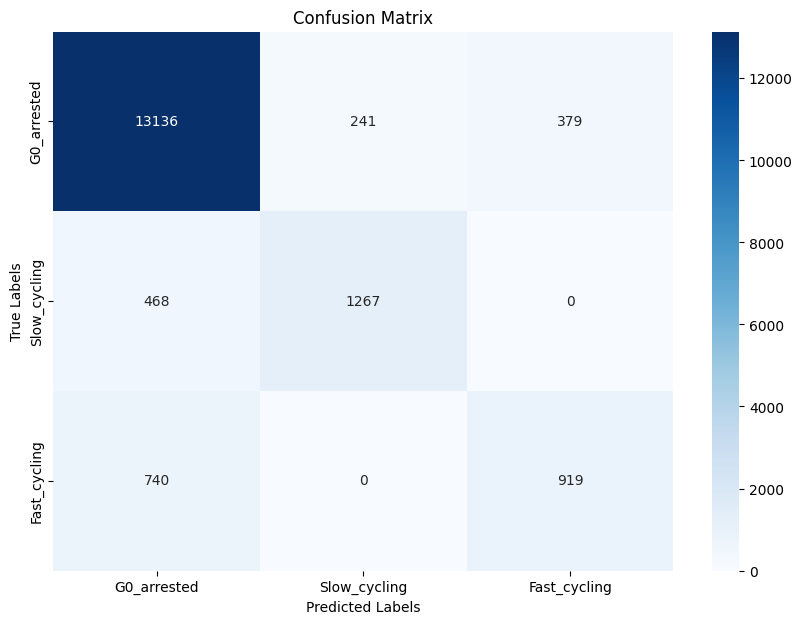

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 pred_list 和 label_list 已经定义
pred_labels = np.argmax(pred_list, axis=1)
true_labels = np.argmax(label_list, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)

# 构建反向标签字典
reverse_label_dict = {v: k for k, v in label_dict.items()}

# 定义想要的顺序
order = ['G0_arrested', 'Slow_cycling', 'Fast_cycling']

# 获取顺序索引
ordered_indices = [label_dict[label] for label in order]

# 重新排列混淆矩阵
ordered_cm = cm[ordered_indices, :][:, ordered_indices]

# 绘制混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(ordered_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=order, yticklabels=order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(save_loc+"confusion.pdf")
plt.show()


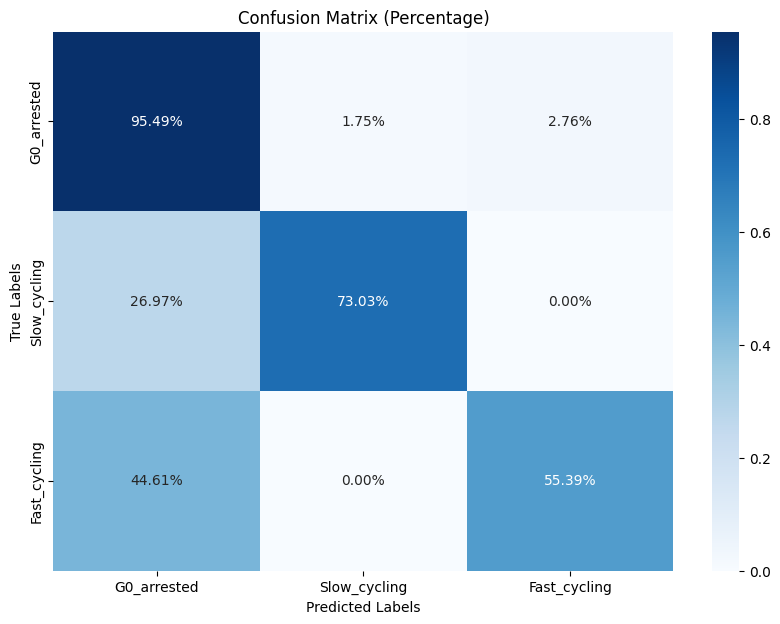

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 pred_list 和 label_list 已经定义
pred_labels = np.argmax(pred_list, axis=1)
true_labels = np.argmax(label_list, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)

# 计算每行（实际类别）的总和
row_sums = cm.sum(axis=1, keepdims=True)

# 将混淆矩阵转换为百分比形式
cm_percentage = cm / row_sums

# 构建反向标签字典
reverse_label_dict = {v: k for k, v in label_dict.items()}

# 定义想要的顺序
order = ['G0_arrested', 'Slow_cycling', 'Fast_cycling']

# 获取顺序索引
ordered_indices = [label_dict[label] for label in order]

# 重新排列混淆矩阵
ordered_cm = cm_percentage[ordered_indices, :][:, ordered_indices]

# 绘制按百分比排列的混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(ordered_cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=order, yticklabels=order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()


/tmp/ipykernel_108785/991111522.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


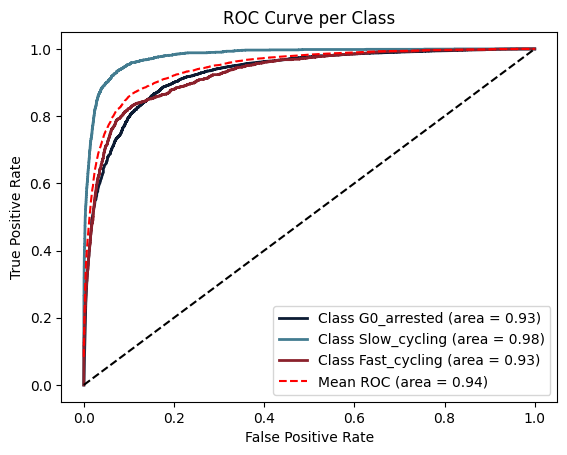

In [15]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt

# 假设 pred_list 和 label_list 已经定义
# pred_list 是模型输出的概率预测
# label_list 是真实的标签

# 指定的顺序
order =['G0_arrested', 'Slow_cycling', 'Fast_cycling']
order_indices = [label_dict[label] for label in order]
colors = ['#0c1b33', '#437c90', '#8b212c', '#f55141', '#ffa360']

# 计算每个类别的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(order):
    class_index = label_dict[label]
    fpr[label], tpr[label], _ = roc_curve(label_list[:, class_index], pred_list[:, class_index])
    roc_auc[label] = auc(fpr[label], tpr[label])

# 计算微观平均ROC曲线和AUC
all_fpr = np.unique(np.concatenate([fpr[label] for label in order]))
mean_tpr = np.zeros_like(all_fpr)
for label in order:
    mean_tpr += interp(all_fpr, fpr[label], tpr[label])
mean_tpr /= len(order)
mean_auc = auc(all_fpr, mean_tpr)

# 计算宏观平均ROC曲线和AUC


# 绘制所有类别的ROC曲线
plt.figure()

for i, label in enumerate(order):
    plt.plot(fpr[label], tpr[label], color=colors[i], lw=2, label=f'Class {label} (area = {roc_auc[label]:.2f})')

# 绘制平均ROC曲线
plt.plot(all_fpr, mean_tpr, label=f'Mean ROC (area = {mean_auc:.2f})',color='red', linestyle='--')

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend(loc="lower right")
plt.savefig(save_loc+"roc_cook_all.pdf")
plt.show()


In [18]:
with open(raw_data_loc,"rb") as f:
    [_,valset_r,_,label_dict] = dill.load(f)

cellLine_cat = valset_r.celltype
# unique in list cellLine_cat
print(list(set(cellLine_cat)))

['Sec.luminal', 'SCGB3A1.Pro', 'Cyc.Pro', 'Cyc.Lac', 'PIP.luminal', 'SAA2.luminal', 'Basal']


/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


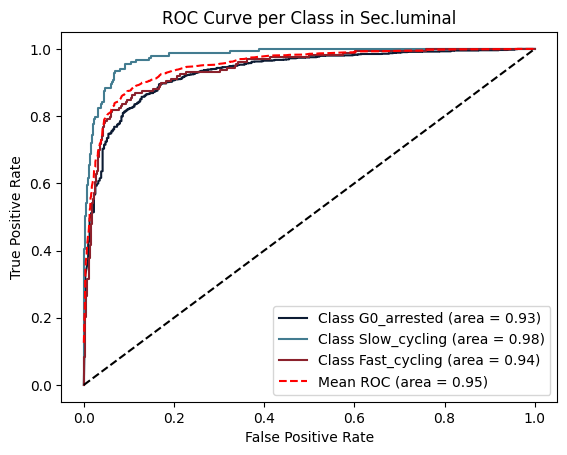

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


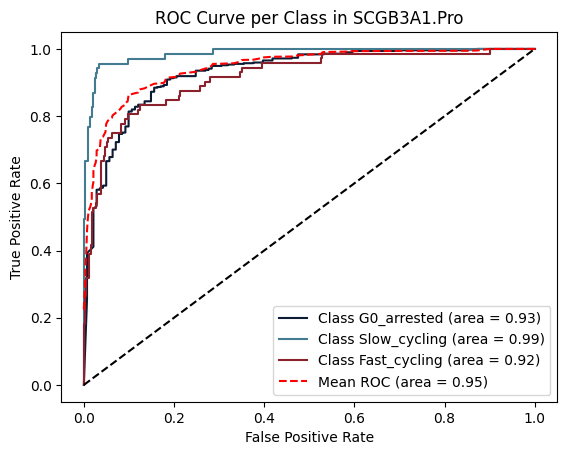

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


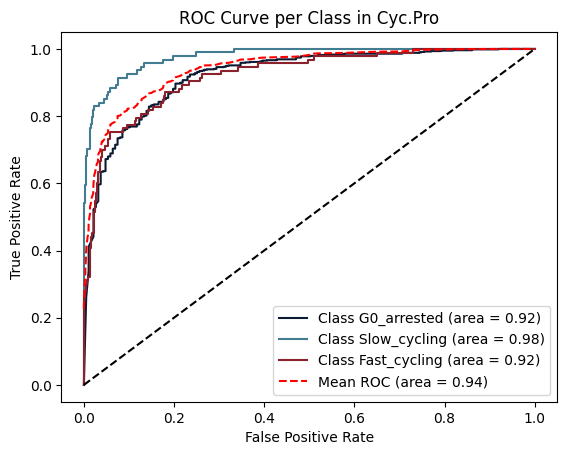

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


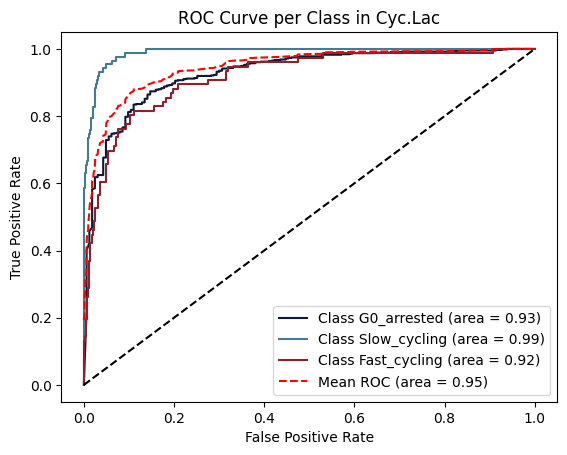

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


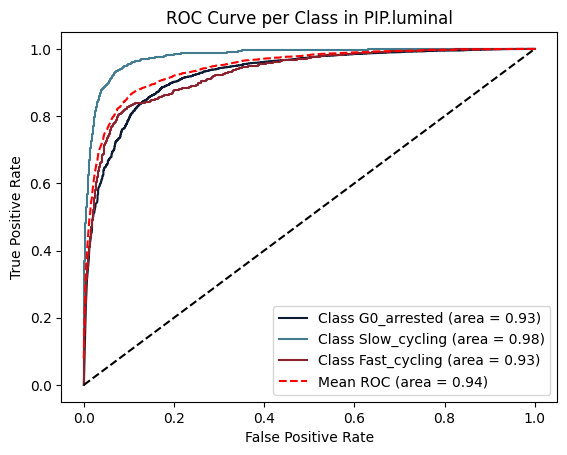

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


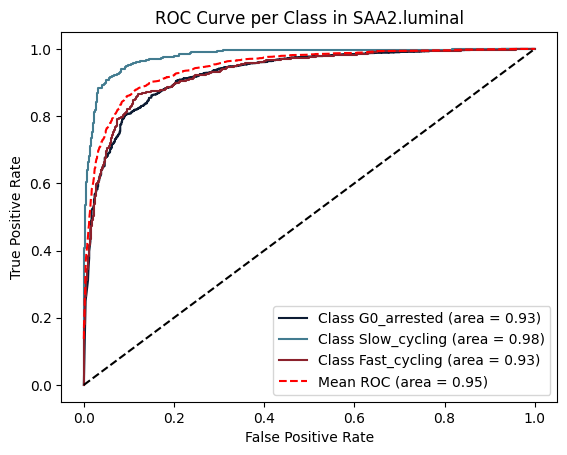

/tmp/ipykernel_108785/3243108567.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[label], tpr[label])


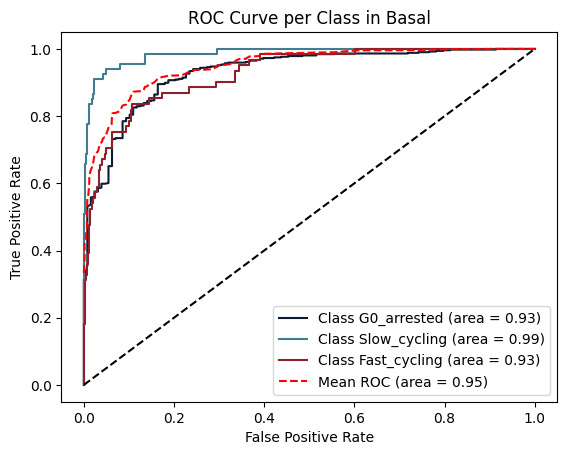

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
# 假设 pred_list 和 label_list 已经定义
for target_cell_line in list(set(cellLine_cat)):
    #target_cell_line = 'Sec.luminal'#['MCF7', 'DU145', 'OVCA420', 'A549']

    indices = [i for i, x in enumerate(cellLine_cat) if x == target_cell_line]
    # pred_list 是模型输出的概率预测
    filtered_pred_list = pred_list[indices]
    filtered_label_list = label_list[indices]

    # 计算每个类别的ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, label in enumerate(order):
        class_index = label_dict[label]
        fpr[label], tpr[label], _ = roc_curve(filtered_label_list[:, class_index], filtered_pred_list[:, class_index])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # 计算微观平均ROC曲线和AUC
    all_fpr = np.unique(np.concatenate([fpr[label] for label in order]))
    mean_tpr = np.zeros_like(all_fpr)
    for label in order:
        mean_tpr += interp(all_fpr, fpr[label], tpr[label])
    mean_tpr /= len(order)
    mean_auc = auc(all_fpr, mean_tpr)

    # 计算宏观平均ROC曲线和AUC


    # 绘制所有类别的ROC曲线
    plt.figure()
    for i,label in enumerate(order):
        plt.plot(fpr[label], tpr[label],color=colors[i], label=f'Class {label} (area = {roc_auc[label]:.2f})')

    # 绘制平均ROC曲线
    plt.plot(all_fpr, mean_tpr,color="red", label=f'Mean ROC (area = {mean_auc:.2f})', linestyle='--')

    # 绘制对角线
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve per Class in {target_cell_line}')
    plt.legend(loc="lower right")
    plt.savefig(save_loc+f"roc_cook_{target_cell_line}.pdf")
    plt.show()
